# 综合前面的知识点

本脚本在iris数据集中处理二分类问题。我们仅仅预测花是否为I.setosa还是不是。

通过创建一个线，并且用sigmoid来得到一个二分类预测器，我们创建一个简单的二分类器。我们使用的两个特征是花瓣长度和宽度。我们使用这两个特征，因为我们知道Iris setosa可以用这两个特征线性可分。我们的目标是找到线性可分的线。

我们使用批量训练方法，但是这很容易的应用到随机训练（例如将批量尺寸设置为1）

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

/home/zhangxin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 加载Iris数据集

我们加载数据集，并且将目标标记I.setosa。输入数据是数据集的第三个和第四个特征（花瓣高度和宽度）

In [2]:
# 加载iris数据集
# iris.target = {0, 1, 2}, '0'表示setosa
# iris.data ~ [sepal.width, sepal.length, pedal.width, pedal.length]
iris = datasets.load_iris()
binary_target = np.array([1. if x==0 else 0. for x in iris.target])
iris_2d = np.array([[x[2], x[3]] for x in iris.data])

批数据尺寸为20

In [3]:
batch_size = 20

In [4]:
# 创建计算图会话
sess = tf.Session()

### 占位符

我们声明模型的占位符。正如前几节中分开喂多个x特征数据的方式一致，我们创建两个分开的占位符，用于两个Iris特征。

In [5]:
# 声明占位符
x1_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
x2_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

### 模型变量

我们准备构建一个线性模型，所以我们创建两个变量`A`和`b`。分别对应slope和intercept。

应该是空间变换和偏移

In [6]:
# 创建变量A和b
A = tf.Variable(tf.random_normal(shape=[1, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

### 模型运算

一个线性模型可以定义为$x_1 = A \cdot x_2 + b$。为了创建一个线性分类器，我们需要看看这些数据点在线的哪一边。有三种可能：

- 点在线上的话，应该满足：$0 = x_1 - (A \cdot x_2 + b)$
- 点在线下面的话，应该满足：$0 > x_1 - (A \cdot x_2 + b)$
- 点在线上面的化，应该满足：$0 < x_1 - (A \cdot x_2 + b)$

我们可以定义模型的输出为：

$$x_{1} - (A \cdot x_{2} + b)$$

然后预测值，可以使用输出的符号来判断

$$Prediction(x_{1},x_{2}) = sign(x_{1} - (A \cdot x_{2} + b))$$

我们把对应的运算加入到计算图中

In [8]:
# 添加模型到计算图中：
# x1 - A*x2 + b
my_mult = tf.matmul(x2_data, A)
my_add = tf.add(my_mult, b)
my_output = tf.subtract(x1_data, my_add)

### 损失函数

因为我们床架你一个多类预测（I.setosa或者不是），我们使用sigmoid交叉熵损失。这个函数是TensorFlow内建的。

In [10]:
# 添加分类损失（交叉熵）
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=my_output, labels=y_target)

### 优化函数和变量初始化

我们使用标准的梯度下降法（学习速率为0.05）。添加后开始运行变量初始化操作。

In [11]:
# 创建优化器
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(xentropy)

# 初始化变量
init = tf.global_variables_initializer()
sess.run(init)

### 运行分类器训练

运行1000次迭代训练，并且输出训练结果A和b，以及每200轮输出损失值。

In [12]:
# 循环
for i in range(1000):
    rand_index = np.random.choice(len(iris_2d), size=batch_size)
    #rand_x = np.transpose([iris_2d[rand_index]])
    rand_x = iris_2d[rand_index]
    rand_x1 = np.array([[x[0]] for x in rand_x])
    rand_x2 = np.array([[x[1]] for x in rand_x])
    #rand_y = np.transpose([binary_target[rand_index]])
    rand_y = np.array([[y] for y in binary_target[rand_index]])
    sess.run(train_step, feed_dict={x1_data: rand_x1, x2_data: rand_x2, y_target: rand_y})
    if (i+1)%200==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)) + ', b = ' + str(sess.run(b)))

Step #200 A = [[8.607348]], b = [[-3.525465]]
Step #400 A = [[10.255231]], b = [[-4.686376]]
Step #600 A = [[11.205536]], b = [[-5.3998837]]
Step #800 A = [[11.908331]], b = [[-5.944199]]
Step #1000 A = [[12.422099]], b = [[-6.409931]]


### 可视化结果

画图，看的更清楚

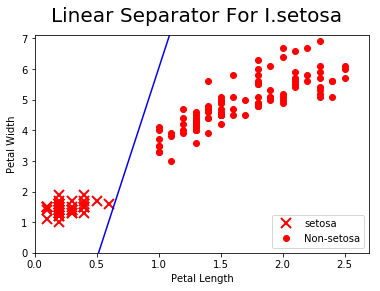

In [13]:
# 答应slope和intercept
[[slope]] = sess.run(A)
[[intercept]] = sess.run(b)

# 创建分割线
x = np.linspace(0, 3, num=50)
ablineValues = []
for i in x:
  ablineValues.append(slope*i+intercept)

# 打印数据和分割线
setosa_x = [a[1] for i,a in enumerate(iris_2d) if binary_target[i]==1]
setosa_y = [a[0] for i,a in enumerate(iris_2d) if binary_target[i]==1]
non_setosa_x = [a[1] for i,a in enumerate(iris_2d) if binary_target[i]==0]
non_setosa_y = [a[0] for i,a in enumerate(iris_2d) if binary_target[i]==0]
plt.plot(setosa_x, setosa_y, 'rx', ms=10, mew=2, label='setosa')
plt.plot(non_setosa_x, non_setosa_y, 'ro', label='Non-setosa')
plt.plot(x, ablineValues, 'b-')
plt.xlim([0.0, 2.7])
plt.ylim([0.0, 7.1])
plt.suptitle('Linear Separator For I.setosa', fontsize=20)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend(loc='lower right')
plt.show()